# ERFNet Keras Implementation
Requirement:Tensorflow 2

# Imports

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

print("Tensorflow version =",tf.__version__)
print("Keras version =",tf.keras.__version__)

Tensorflow version = 2.0.0-beta1
Keras version = 2.2.4-tf


# Prepare Data

# Define Model

## Define Custom Layers

### 1. DownsamplerBlock
- **Desc**: Takes a ninput deep tensor and transform it in a nouput deep tensor 
- **Status**: Looks good, Hard coded 16 and 64
- **TODO**: Generalize for any ninput and noutput value

#### Original Pytorch Code:

```python
class DownsamplerBlock (nn.Module):
    def __init__(self, ninput, noutput):
        super().__init__()
        self.conv = nn.Conv2d(ninput, noutput-ninput, (3, 3), stride=2, padding=1, bias=True)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.bn = nn.BatchNorm2d(noutput, eps=1e-3)
    def forward(self, input):
        output = torch.cat([self.conv(input), self.pool(input)], 1)
        output = self.bn(output)
        return F.relu(output)
```

#### My Keras implementation:

In [16]:
class DownsamplerBlock (Model):
    def __init__(self, ninput, noutput):
        super(DownsamplerBlock,self).__init__()

        self.conv = layers.Conv2D(filters=noutput-ninput,kernel_size=3,strides=2,padding="same", use_bias=True)
        self.pool = layers.MaxPool2D(pool_size = 2,strides = 2,padding = "same")
        self.bn = layers.BatchNormalization(epsilon = 1e-03)
    
    def call(self, x):
        y = layers.Concatenate([self.conv(x), self.pool(x)])
        y = self.bn(y)
        y = layers.ReLU()(y)
        return y

### 1.a DownsamplerBlock 3,16
- **Desc**: Takes a 3 deep tensor and transform it in a 16 deep tensor 
- **Status**: Looks good, Hard coded 16 and 64
- **TODO**: Generalize for any ninput and noutput value

Model: "dwn16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
original_img (InputLayer)       [(None, 1280, 720, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 640, 360, 13) 364         original_img[0][0]               
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 640, 360, 3)  0           original_img[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 640, 360, 16) 0           conv2d[0][0]                     
                                                                 max_pooling2d[0][0]          

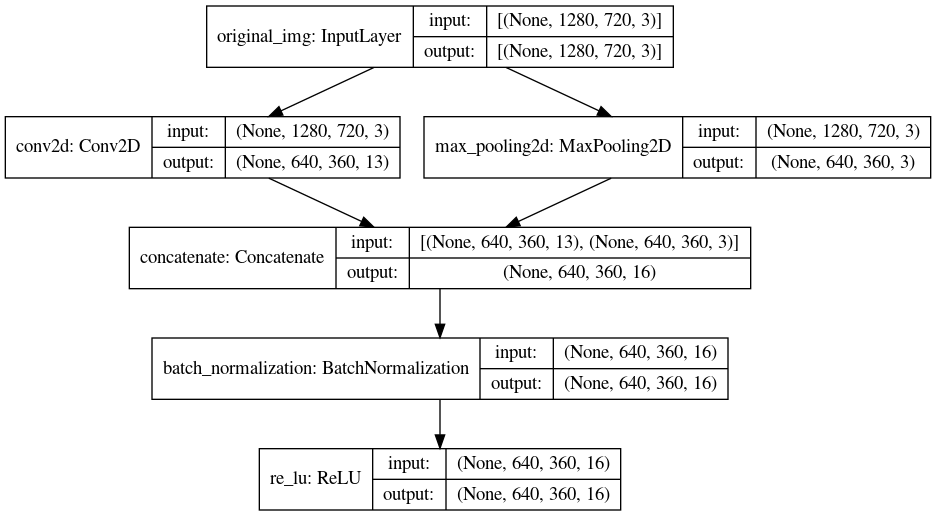

In [2]:
imgsize = [1280,720]
dwn16_input = tf.keras.Input(shape=(imgsize[0],imgsize[1], 3), name='original_img')
a = layers.Conv2D(filters=16-3,kernel_size=3,strides=2,padding="same", use_bias=True)(dwn16_input)
b = layers.MaxPool2D(pool_size = 2,strides = 2,padding = "same")(dwn16_input)
y = layers.concatenate([a, b],axis=-1)
y = layers.BatchNormalization(axis = -1, epsilon = 1e-03)(y)
dwn16_output = layers.ReLU()(y)
dwn16 = tf.keras.Model(dwn16_input, dwn16_output, name='dwn16')
dwn16.summary()
tf.keras.utils.plot_model(dwn16, 'dwn16.png', show_shapes=True)

### 1.b DownsamplerBlock 16,64
- **Desc**: Takes a 16 deep tensor and transform it in a 64 deep tensor 
- **Status**: Looks good, Hard coded 16 and 64
- **TODO**: Generalize for any ninput and noutput value

Model: "dwn64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
filtered_img (InputLayer)       [(None, 640, 360, 16 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 180, 48) 6960        filtered_img[0][0]               
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 320, 180, 16) 0           filtered_img[0][0]               
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 320, 180, 64) 0           conv2d_1[0][0]                   
                                                                 max_pooling2d_1[0][0]        

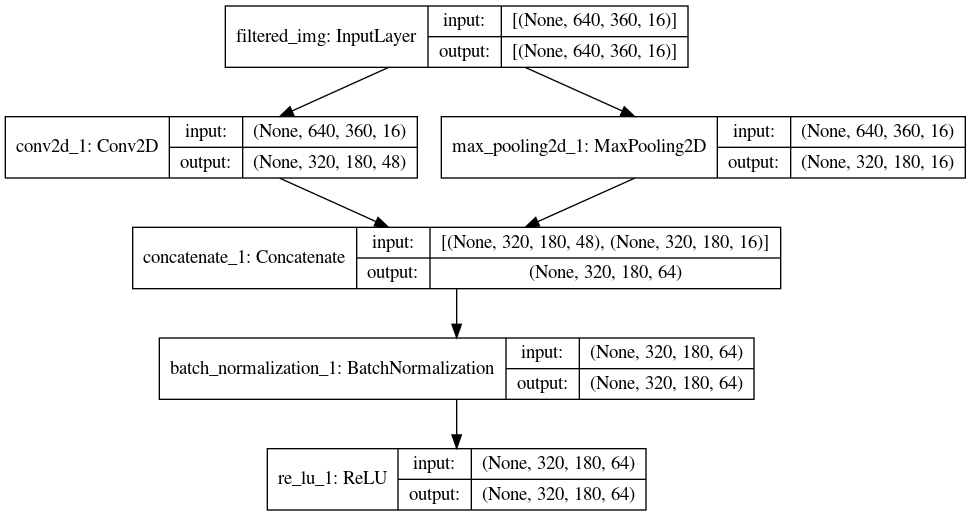

In [3]:
dwn64_input = tf.keras.Input(shape= (dwn16.output_shape[1],dwn16.output_shape[2], dwn16.output_shape[3]), name='filtered_img')
a = layers.Conv2D(filters=64-16,kernel_size=3,strides=2,padding="same", use_bias=True)(dwn64_input)
b = layers.MaxPool2D(pool_size = 2,strides = 2,padding = "same")(dwn64_input)
y = layers.concatenate([a, b],axis=-1)
y = layers.BatchNormalization(axis = -1, epsilon = 1e-03)(y)
dwn64_output = layers.ReLU()(y)
dwn64 = tf.keras.Model(dwn64_input, dwn64_output, name='dwn64')
dwn64.summary()
tf.keras.utils.plot_model(dwn64, 'dwn64.png', show_shapes=True)

### 2. UpsamplerBlock
- **Desc**:
- **Status**: Translated in Keras, need to check usability
- **TODO**:

#### Original Pytorch Code:

```python
class UpsamplerBlock (nn.Module):
    def __init__(self, ninput, noutput):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ninput, noutput, 3, stride=2, padding=1, output_padding=1, bias=True)
        self.bn = nn.BatchNorm2d(noutput, eps=1e-3)

    def forward(self, input):
        output = self.conv(input)
        output = self.bn(output)
        return F.relu(output)
```

#### My Keras implementation:

In [4]:
class UpsamplerBlock (Model):
    def __init__(self, ninput, noutput):
        super(UpsamplerBlock,self).__init__(name='upsampler')
        self.conv = layers.Conv2DTranspose(filters=noutput, kernel_size=3, strides=2, padding="same", output_padding=1, use_bias=True)
        self.bn = layers.BatchNormalization(epsilon=1e-3)
    def call(self, x):
        y = self.conv(x)
        y = self.bn(y)
        y = layers.ReLU()(y)
        return y

### 3. non_bottleneck_1d
- **Desc**: Factorised Resnet layer
- **Status**: Looks good
- **TODO**:

#### Original Pytorch Code:

```python
class non_bottleneck_1d (nn.Module):
    def __init__(self, chann, dropprob, dilated):        
        super().__init__()
        self.conv3x1_1 = nn.Conv2d(chann, chann, (3, 1), stride=1, padding=(1,0), bias=True)
        self.conv1x3_1 = nn.Conv2d(chann, chann, (1,3), stride=1, padding=(0,1), bias=True)
        self.bn1 = nn.BatchNorm2d(chann, eps=1e-03)
        self.conv3x1_2 = nn.Conv2d(chann, chann, (3, 1), stride=1, padding=(1*dilated,0), bias=True, dilation = (dilated,1))
        self.conv1x3_2 = nn.Conv2d(chann, chann, (1,3), stride=1, padding=(0,1*dilated), bias=True, dilation = (1, dilated))
        self.bn2 = nn.BatchNorm2d(chann, eps=1e-03)
        self.dropout = nn.Dropout2d(dropprob)
    def forward(self, input):
        output = self.conv3x1_1(input)
        output = F.relu(output)
        output = self.conv1x3_1(output)
        output = self.bn1(output)
        output = F.relu(output)
        output = self.conv3x1_2(output)
        output = F.relu(output)
        output = self.conv1x3_2(output)
        output = self.bn2(output)
        if (self.dropout.p != 0):
            output = self.dropout(output)
        return F.relu(output+input)    #+input = identity (residual connection)
```

#### My Keras implementation:

In [5]:
class non_bottleneck_1d (Model):
    def __init__(self, chann, dropprob, dilated):        
        super(non_bottleneck_1d,self).__init__()
        self.conv3x1_1 = layers.Conv2D(filters=chann,kernel_size=(3, 1),strides=1,padding="same", use_bias=True)
        self.conv1x3_1 = layers.Conv2D(filters=chann,kernel_size=(1, 3),strides=1,padding="same", use_bias=True)
        self.bn1 = layers.BatchNormalization(epsilon=1e-3)
        self.conv3x1_2 = layers.Conv2D(filters=chann,kernel_size=(3, 1),strides=1,padding="same", use_bias=True, dilation_rate=(dilated,1))
        self.conv1x3_2 = layers.Conv2D(filters=chann,kernel_size=(1, 3),strides=1,padding="same", use_bias=True, dilation_rate=(1, dilated))
        self.bn2 = layers.BatchNormalization(epsilon=1e-3)
        self.dropout = layers.Dropout(dropprob)
    def  call(self, input, training=False):
        y = self.conv3x1_1(input)
        y = layers.ReLU()(y)
        y = self.conv1x3_1(y)
        y = self.bn1(y)
        y = layers.ReLU()(y)
        y = self.conv3x1_2(y)
        y = layers.ReLU()(y)
        y = self.conv1x3_2(y)
        y = self.bn2(y)
        if training:
            y = self.dropout(y)
        y = layers.add([input, y])
        return layers.ReLU()(y)

### 3.a non_bottleneck_1d 64
- **Desc**: Factorised Resnet layer x5
- **Status**: Looks good
- **TODO**:

Model: "nb1d64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
filtered_img (InputLayer)    [(None, 320, 180, 64)]    0         
_________________________________________________________________
non_bottleneck_1d (non_bottl (None, 320, 180, 64)      49920     
_________________________________________________________________
non_bottleneck_1d_1 (non_bot (None, 320, 180, 64)      49920     
_________________________________________________________________
non_bottleneck_1d_2 (non_bot (None, 320, 180, 64)      49920     
_________________________________________________________________
non_bottleneck_1d_3 (non_bot (None, 320, 180, 64)      49920     
_________________________________________________________________
non_bottleneck_1d_4 (non_bot (None, 320, 180, 64)      49920     
Total params: 249,600
Trainable params: 248,320
Non-trainable params: 1,280
__________________________________________________

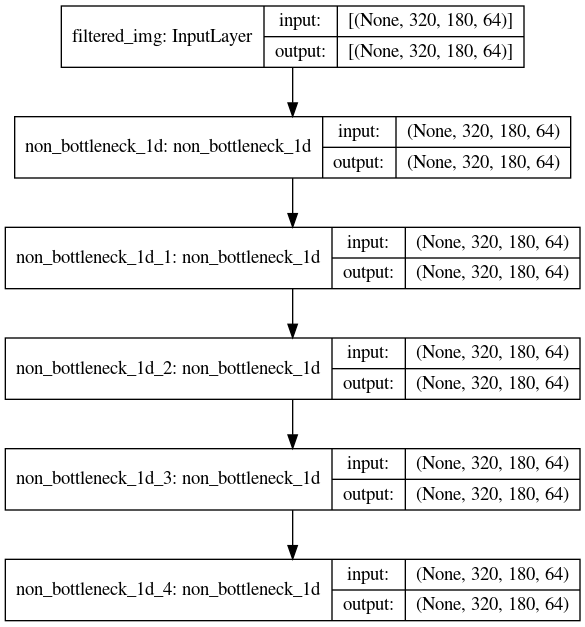

In [6]:
nb1d64_input = tf.keras.Input(shape= (dwn64.output_shape[1],dwn64.output_shape[2], dwn64.output_shape[3]), name='filtered_img')
y = nb1d64_input
for i in range (0,5):
    y = non_bottleneck_1d(64, 0.03, 1)(y)
nb1d64_output = y
nb1d64 = tf.keras.Model(nb1d64_input, nb1d64_output, name='nb1d64')
nb1d64.summary()
tf.keras.utils.plot_model(nb1d64, 'nb1d64.png', show_shapes=True)

### 1.c DownsamplerBlock 64,128
- **Desc**: Takes a 64 deep tensor and transform it in a 128 deep tensor 
- **Status**: Looks good, Hard coded 16 and 64
- **TODO**: Generalize for any ninput and noutput value

Model: "dwn128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
filtered_img (InputLayer)       [(None, 320, 180, 64 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 160, 90, 64)  36928       filtered_img[0][0]               
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 160, 90, 64)  0           filtered_img[0][0]               
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 160, 90, 128) 0           conv2d_22[0][0]                  
                                                                 max_pooling2d_2[0][0]       

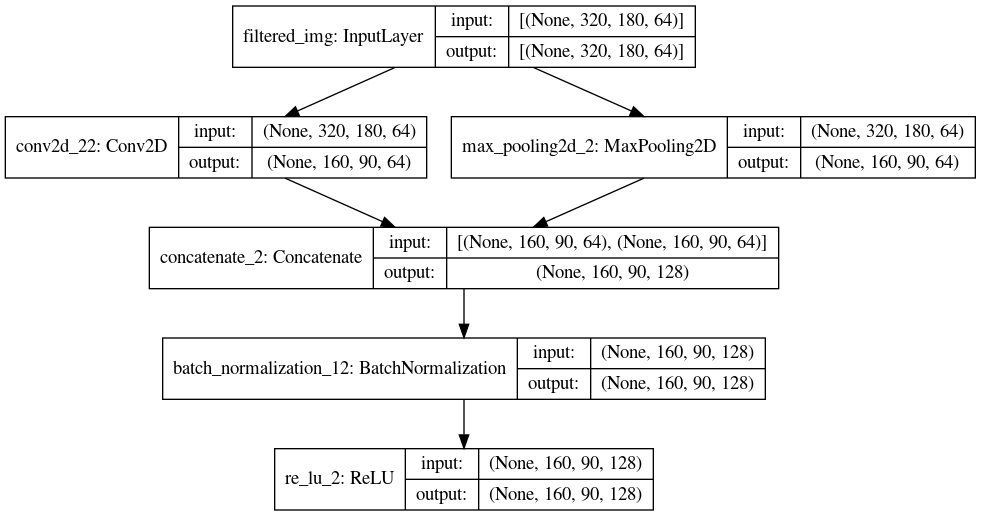

In [7]:
dwn128_input = tf.keras.Input(shape= (nb1d64.output_shape[1],nb1d64.output_shape[2], nb1d64.output_shape[3]), name='filtered_img')
a = layers.Conv2D(filters=128-64,kernel_size=3,strides=2,padding="same", use_bias=True)(dwn128_input)
b = layers.MaxPool2D(pool_size = 2,strides = 2,padding = "same")(dwn128_input)
y = layers.concatenate([a, b],axis=-1)
y = layers.BatchNormalization(axis = -1, epsilon = 1e-03)(y)
dwn128_output = layers.ReLU()(y)

dwn128 = tf.keras.Model(dwn128_input, dwn128_output, name='dwn128')
dwn128.summary()
tf.keras.utils.plot_model(dwn128, 'dwn128.png', show_shapes=True)

### 3.c non_bottleneck_1d 128
- **Desc**: Factorised Resnet layer x8
- **Status**: Looks good
- **TODO**:

Model: "nb1d128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
filtered_img (InputLayer)    [(None, 160, 90, 128)]    0         
_________________________________________________________________
non_bottleneck_1d_5 (non_bot (None, 160, 90, 128)      198144    
_________________________________________________________________
non_bottleneck_1d_6 (non_bot (None, 160, 90, 128)      198144    
_________________________________________________________________
non_bottleneck_1d_7 (non_bot (None, 160, 90, 128)      198144    
_________________________________________________________________
non_bottleneck_1d_8 (non_bot (None, 160, 90, 128)      198144    
_________________________________________________________________
non_bottleneck_1d_9 (non_bot (None, 160, 90, 128)      198144    
_________________________________________________________________
non_bottleneck_1d_10 (non_bo (None, 160, 90, 128)      1981

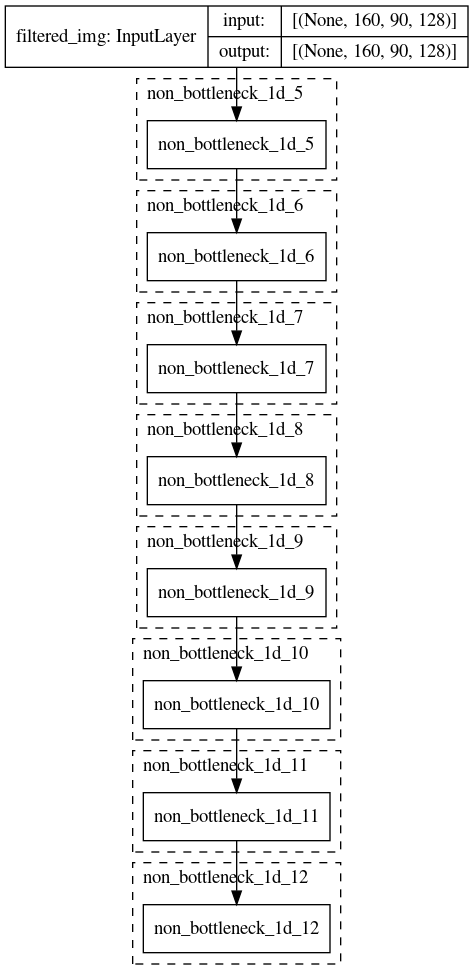

In [8]:
nb1d128_input = tf.keras.Input(shape= (dwn128.output_shape[1],dwn128.output_shape[2], dwn128.output_shape[3]), name='filtered_img')
y = nb1d128_input
for i in range (0,2):
    y = non_bottleneck_1d(128, 0.3, 2)(y)
    y = non_bottleneck_1d(128, 0.3, 4)(y)
    y = non_bottleneck_1d(128, 0.3, 8)(y)
    y = non_bottleneck_1d(128, 0.3, 16)(y)
nb1d128_output = y
nb1d128 = tf.keras.Model(nb1d128_input, nb1d128_output, name='nb1d128')
nb1d128.summary()
tf.keras.utils.plot_model(nb1d128, 'nb1d128.png',expand_nested=True, show_shapes=True)

### 2.a UpsamplerBlock64
- **Desc**:
- **Status**: Translated in Keras, need to check usability
- **TODO**:

Model: "up64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
filtered_img (InputLayer)    [(None, 160, 90, 128)]    0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 320, 180, 64)      73792     
_________________________________________________________________
batch_normalization_29 (Batc (None, 320, 180, 64)      256       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 320, 180, 64)      0         
Total params: 74,048
Trainable params: 73,920
Non-trainable params: 128
_________________________________________________________________


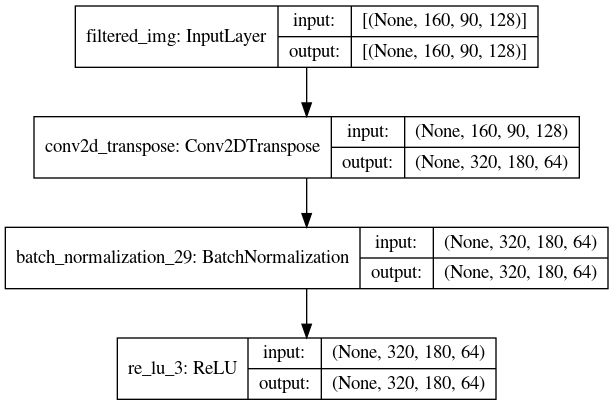

In [9]:
up64_input = tf.keras.Input(shape= (nb1d128.output_shape[1],nb1d128.output_shape[2], nb1d128.output_shape[3]), name='filtered_img')
y = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same", output_padding=1, use_bias=True)(up64_input)
y = layers.BatchNormalization(epsilon=1e-3)(y)
up64_output = layers.ReLU()(y)
up64 = tf.keras.Model(up64_input, up64_output, name='up64')
up64.summary()
tf.keras.utils.plot_model(up64, 'up64.png', show_shapes=True)

### 4. Encoder
- **Desc**:
- **Status**: Work in progress
- **TODO**:

#### Original Pytorch Code:

```python
class Encoder(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.initial_block = DownsamplerBlock(3,16)
        self.layers = nn.ModuleList()
        self.layers.append(DownsamplerBlock(16,64))
        for x in range(0, 5):    #5 times
           self.layers.append(non_bottleneck_1d(64, 0.03, 1)) 
        self.layers.append(DownsamplerBlock(64,128))
        for x in range(0, 2):    #2 times
            self.layers.append(non_bottleneck_1d(128, 0.3, 2))
            self.layers.append(non_bottleneck_1d(128, 0.3, 4))
            self.layers.append(non_bottleneck_1d(128, 0.3, 8))
            self.layers.append(non_bottleneck_1d(128, 0.3, 16))
        #Only in encoder mode:
        self.output_conv = nn.Conv2d(128, num_classes, 1, stride=1, padding=0, bias=True)
    def forward(self, input, predict=False):
        output = self.initial_block(input)
        for layer in self.layers:
            output = layer(output)
        if predict:
            output = self.output_conv(output)
        return output
```

#### My Keras implementation:

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 1280, 720, 3)]    0         
_________________________________________________________________
dwn16 (Model)                (None, 640, 360, 16)      428       
_________________________________________________________________
dwn64 (Model)                (None, 320, 180, 64)      7216      
_________________________________________________________________
nb1d64 (Model)               (None, 320, 180, 64)      249600    
_________________________________________________________________
dwn128 (Model)               (None, 160, 90, 128)      37440     
_________________________________________________________________
nb1d128 (Model)              (None, 160, 90, 128)      1585152   
Total params: 1,879,836
Trainable params: 1,874,044
Non-trainable params: 5,792
_____________________________________________

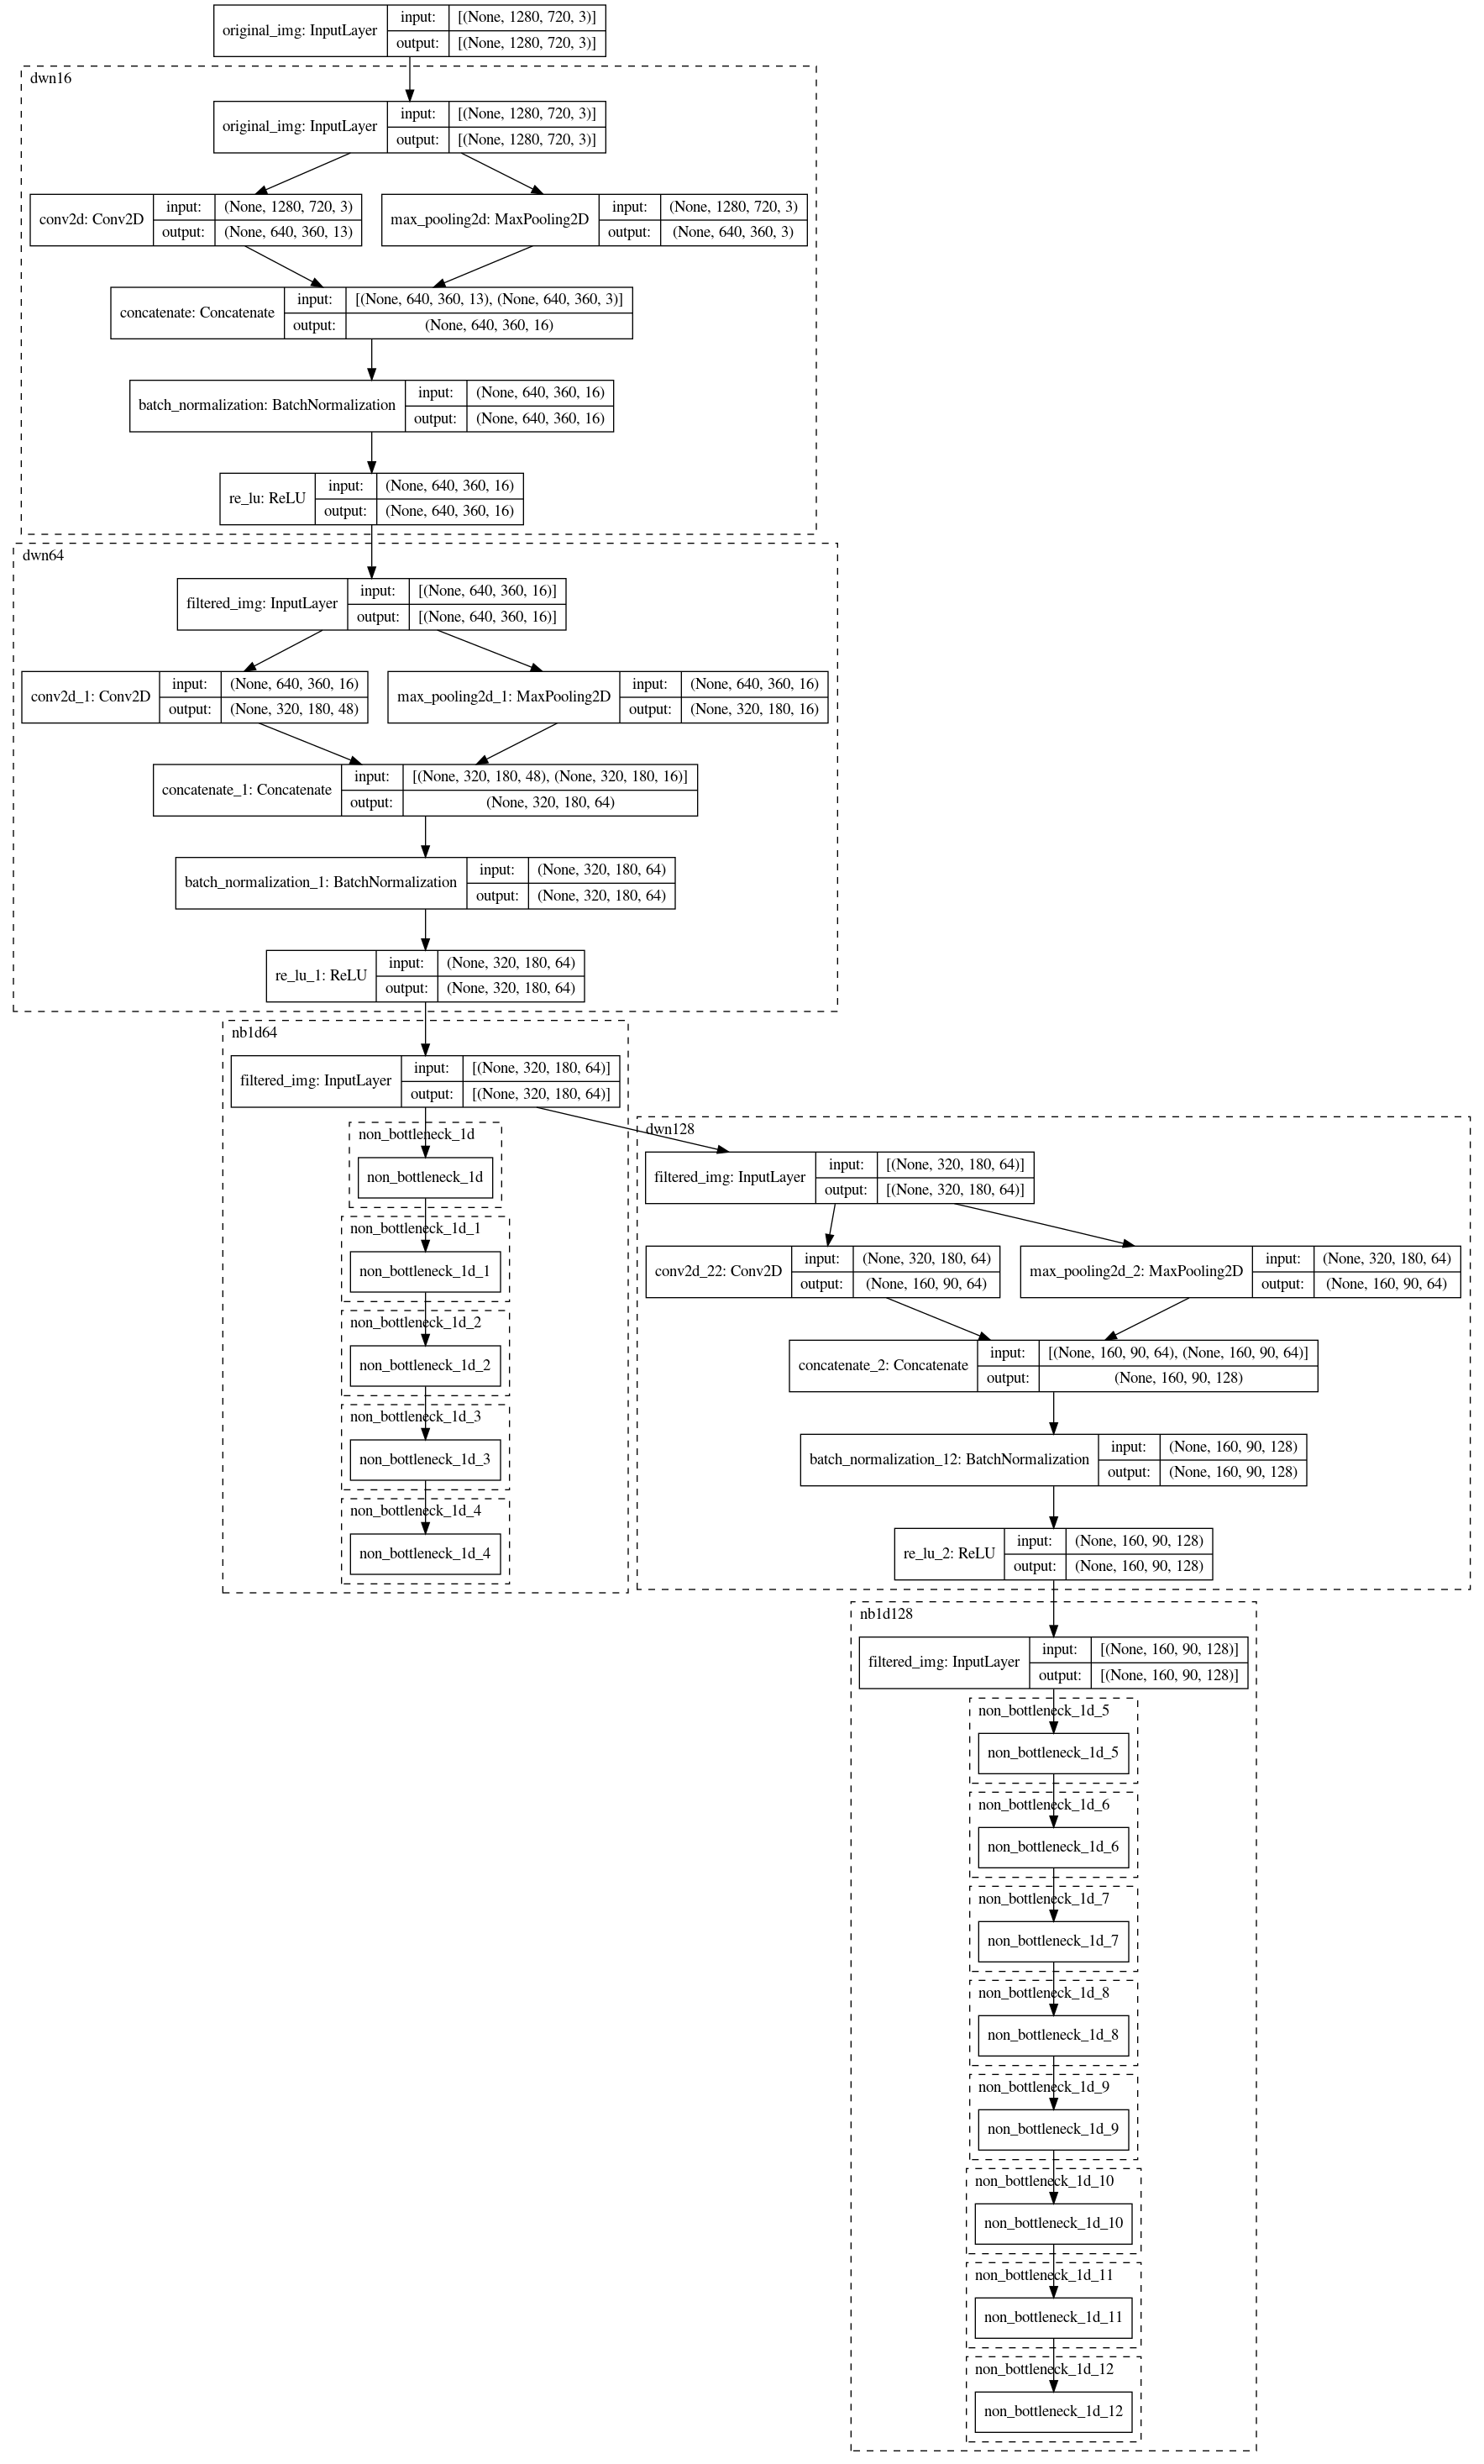

In [10]:
encoder_input = tf.keras.Input(shape=(1280, 720, 3), name='original_img')
y = dwn16(encoder_input)
y = dwn64(y)
y = nb1d64(y)
y = dwn128(y)
y = nb1d128(y)
encoder_output = y
encoder = tf.keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()
tf.keras.utils.plot_model(encoder, 'encoder.png', show_shapes=True, expand_nested=True)

In [17]:
encoder_input = tf.keras.Input(shape=(1280, 720, 3), name='original_img')
y = DownsamplerBlock(3,16)(encoder_input)
y = DownsamplerBlock(16,64)(y)
for i in range (0,5):
    y = non_bottleneck_1d(64, 0.03, 1)(y)
y = DownsamplerBlock(64,128)(y)
for i in range (0,2):
    y = non_bottleneck_1d(128, 0.3, 2)(y)
    y = non_bottleneck_1d(128, 0.3, 4)(y)
    y = non_bottleneck_1d(128, 0.3, 8)(y)
    y = non_bottleneck_1d(128, 0.3, 16)(y)
encoder_output = y
encoder = tf.keras.Model(encoder_input, encoder_output, name='encoder2')
encoder.summary()
tf.keras.utils.plot_model(encoder, 'encoder2.png', show_shapes=True, expand_nested=True)

ValueError: in converted code:

    <ipython-input-14-10e35e63a9a9>:11 call  *
        y = self.bn(y)
    /home/artyom/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:709 __call__
        self._maybe_build(inputs)
    /home/artyom/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1966 _maybe_build
        self.build(input_shapes)
    /home/artyom/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/keras/layers/normalization.py:270 build
        raise ValueError('Input has undefined rank:', input_shape)

    ValueError: ('Input has undefined rank:', TensorShape(None))


### 5. Decoder
- **Desc**:
- **Status**: Work in progress
- **TODO**:

#### Original Pytorch Code:

```python
class Decoder (nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(UpsamplerBlock(128,64))
        self.layers.append(non_bottleneck_1d(64, 0, 1))
        self.layers.append(non_bottleneck_1d(64, 0, 1))
        self.layers.append(UpsamplerBlock(64,16))
        self.layers.append(non_bottleneck_1d(16, 0, 1))
        self.layers.append(non_bottleneck_1d(16, 0, 1))
        self.output_conv = nn.ConvTranspose2d( 16, num_classes, 2, stride=2, padding=0, output_padding=0, bias=True)
    def forward(self, input):
        output = input
        for layer in self.layers:
            output = layer(output)
        output = self.output_conv(output)
        return output
```

#### My Keras implementation:

In [ ]:
class Decoder (nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.layers = nn.ModuleList()

        self.layers.append(UpsamplerBlock(128,64))
        self.layers.append(non_bottleneck_1d(64, 0, 1))
        self.layers.append(non_bottleneck_1d(64, 0, 1))

        self.layers.append(UpsamplerBlock(64,16))
        self.layers.append(non_bottleneck_1d(16, 0, 1))
        self.layers.append(non_bottleneck_1d(16, 0, 1))

        self.output_conv = nn.ConvTranspose2d( 16, num_classes, 2, stride=2, padding=0, output_padding=0, bias=True)

    def forward(self, input):
        output = input

        for layer in self.layers:
            output = layer(output)

        output = self.output_conv(output)

        return output

## Define Custom Model

#### Original Pytorch Code:

```python
class Net(nn.Module):
    def __init__(self, num_classes, encoder=None):  #use encoder to pass pretrained encoder
        super().__init__()

        if (encoder == None):
            self.encoder = Encoder(num_classes)
        else:
            self.encoder = encoder
        self.decoder = Decoder(num_classes)

    def forward(self, input, only_encode=False):
        if only_encode:
            return self.encoder.forward(input, predict=True)
        else:
            output = self.encoder(input)    #predict=False by default
            return self.decoder.forward(output)
```

#### My Keras implementation:

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes, encoder=None):  #use encoder to pass pretrained encoder
        super().__init__()

        if (encoder == None):
            self.encoder = Encoder(num_classes)
        else:
            self.encoder = encoder
        self.decoder = Decoder(num_classes)

    def forward(self, input, only_encode=False):
        if only_encode:
            return self.encoder.forward(input, predict=True)
        else:
            output = self.encoder(input)    #predict=False by default
            return self.decoder.forward(output)

# Train Model

# Evaluate Model

## Quantitave results

## Qualitative results

# Use Model

In [ ]:
encoder_input = tf.keras.Input(shape=(28, 28, 1), name='original_img')
x = layers.Conv2D(16, 3, activation='relu')(encoder_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = tf.keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

decoder_input = tf.keras.Input(shape=(16,), name='encoded_img')
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation='relu')(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='relu')(x)

decoder = tf.keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

autoencoder_input = tf.keras.Input(shape=(28, 28, 1), name='img')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = tf.keras.Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()

In [ ]:
tf.keras.utils.plot_model(autoencoder, 'downs.png')